3. CLASIFICACION DE SELLERS

### Se propondrán 3 formas de clasificar a los sellers, se compararán los resultados y se optará por una solución

In [1]:
# Importamos las librerias
import pandas as pd

In [132]:
# Importamos los datos
data = pd.read_csv('../data/20220318_dataset_sellers.csv',index_col=None)

In [136]:
# Seleccionaremos las variables que se utilizarán para clasificar los sellers
# dado que hay variables en frecuencia  y porcentaje, se optará por las que representan el porcentaje
# Se quitarán del análisis las variables referidas a la categoria del cliente, estado de vendedor actual y termometro
data = data[['antiquity_ages', 'cancellations_rate', 
       'claims_rate', 'delayed_handling_time_rate', 'sales_value',
       'transactions_canceled_historic_rate',
       'rating_positive', 'total_sales_amount', 'total_items_sold',
       'total_profits_amount']]

In [137]:
estadisticos = data.describe().apply(lambda y: y.apply(lambda x: format(x, 'f')))
estadisticos

,antiquity_ages,cancellations_rate,claims_rate,delayed_handling_time_rate,sales_value,transactions_canceled_historic_rate,rating_positive,total_sales_amount,total_items_sold,total_profits_amount
count,5399.000000,5399.000000,5399.000000,5399.000000,5399.000000,5399.000000,5399.000000,5399.000000,5399.000000,5399.000000
mean,7.399889,0.002370,0.005494,0.024621,2489.728839,0.051232,0.966783,10174952.166861,2256.905909,2034990.433340
std,5.336329,0.004146,0.005859,0.032194,6538.907571,0.027795,0.051218,60504896.770264,10817.642740,12100979.355539
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.002300,327.000000,0.035292,0.960000,289120.910000,68.000000,57824.200000
50%,6.000000,0.000000,0.004300,0.011600,885.000000,0.046494,0.980000,1249750.000000,450.000000,249950.000000
75%,11.000000,0.003600,0.009500,0.034250,2427.000000,0.060843,0.990000,4883041.000000,1025.000000,976608.200000
max,22.000000,0.036200,0.039500,0.210500,213079.000000,0.900000,1.000000,2766589430.000000,424622.000000,553317886.000000


### 3. a. Clasificacion en base a percentiles (EN CONSTRUCCION)

#### Para esta solucion se aplicarán umbrales en base a los percentiles de cada variable de interes
Se separarán los sellers en 3 grupos: 
1. Muy Alto = todos los umbrales positivos 
2. Alto
3. Medio

#### Metricas positivas
- rating_positive
- total_sales_amount
- total_items_sold
- total_profits_amount

#### Metricas negativas
- cancellations_rate
- claims_rate
- delayed_handling_time_rate
- transactions_canceled_historic_rate

In [109]:
# Definimos el grupo Muy Alto,

sellers_MA = data.loc[
                    # negativo
                    ((data.cancellations_rate <= float(estadisticos.cancellations_rate['25%']) ) | # Cancelaciones en los últimos 60 días menor o igual a q3
                    (data.claims_rate <= float(estadisticos.claims_rate['25%']) ) | # reclamos en los últimos 60 días menor o igual a q3
                    (data.delayed_handling_time_rate <= float(estadisticos.delayed_handling_time_rate['25%']) ) | # demoras en los últimos 60 días menor o igual a q3
                    (data.transactions_canceled_historic_rate <= float(estadisticos.transactions_canceled_historic_rate['25%']) ) ) # Cancelaciones historicas igual o menores a Q3
                    & 
                    # positivo
                    ((data.sales_value >= float(estadisticos.sales_value['75%']) ) | # Ventas igual o mayores al Q1
                    (data.rating_positive >= float(estadisticos.rating_positive['75%']) ) | # Ranking positivo mayor o igual al Q1
                    (data.total_sales_amount >= float(estadisticos.total_sales_amount['75%']) ) | # Total de ventas mayor o igual al Q1
                    (data.total_items_sold >= float(estadisticos.total_items_sold['75%']) ) | # Total de items vendidos mayor o igual al Q1  
                    (data.total_profits_amount >= float(estadisticos.total_profits_amount['75%']))) # Total de ganancias obtenidasmayor o igual al Q1
                    ].reset_index(drop=True)
len(sellers_MA)

AttributeError: 'DataFrame' object has no attribute 'sales_value'

In [ ]:
sellers_MA

,seller,state,city,antiquity_ages,cancellations_rate,claims_rate,delayed_handling_time_rate,sales_value,transactions_canceled_historic_rate,rating_negative,rating_neutral,rating_positive,total_sales_amount,total_items_sold,total_profits_amount
3,435859328,Santa Fe,Santa Fe,2,0.0000,0.0026,0.0030,3604,0.047037,0.01,0.01,0.98,4302180.0,4000,860436.0
5,671347056,Buenos Aires,Villa Celina,1,0.0000,0.0049,0.0000,10149,0.057071,0.02,0.01,0.97,72666786.0,12224,14533357.2
6,24613228,Capital Federal,Paternal,12,0.0012,0.0048,0.0033,3202,0.028305,0.02,0.02,0.96,14446275.0,8125,2889255.0
7,9048891,Capital Federal,Villa Crespo,19,0.0000,0.0088,0.0054,2055,0.044715,0.02,0.03,0.95,2734975.0,1250,546995.0
10,122876289,Capital Federal,Caballito,9,0.0000,0.0000,0.0226,474,0.059459,0.00,0.00,1.00,1964589.0,111,392917.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5393,661848292,Capital Federal,Lugano,1,0.0035,0.0056,0.0000,3283,0.022145,0.01,0.02,0.97,45000.0,250,9000.0
5394,142182090,Capital Federal,Villa Urquiza,8,0.0000,0.0000,0.0000,100,0.040404,0.00,0.00,1.00,84500.0,25,16900.0
5395,12442171,Capital Federal,Parque Chacabuco,10,0.0000,0.0000,0.0058,178,0.043728,0.00,0.01,0.99,484000.0,200,96800.0
5396,459092675,Capital Federal,Belgrano,2,0.0000,0.0000,0.0000,385,0.006711,0.00,0.00,1.00,172500.0,250,34500.0


In [ ]:
sellers_M = data.loc[
                    # negativo
                    ((data.cancellations_rate > float(estadisticos.cancellations_rate['25%']) ) | # Cancelaciones en los últimos 60 días mayor a q3
                    (data.claims_rate > float(estadisticos.claims_rate['25%']) ) | # reclamos en los últimos 60 días mayor a q3
                    (data.delayed_handling_time_rate > float(estadisticos.delayed_handling_time_rate['25%']) ) | # demoras en los últimos 60 días mayor a q3
                    (data.transactions_canceled_historic_rate > float(estadisticos.transactions_canceled_historic_rate['25%']) ) ) # Cancelaciones historicas mayores a Q3
                    & 
                    # positivo
                    ((data.sales_value < float(estadisticos.sales_value['75%']) ) | # Ventas menores al Q1
                    (data.rating_positive < float(estadisticos.rating_positive['75%']) ) | # Ranking positivo  menores al Q1
                    (data.total_sales_amount < float(estadisticos.total_sales_amount['75%']) ) | # Total de ventas  menores al Q1
                    (data.total_items_sold < float(estadisticos.total_items_sold['75%']) ) | # Total de items vendidos  menores al Q1  
                    (data.total_profits_amount < float(estadisticos.total_profits_amount['75%']))) # Total de ganancias obtenidas menores al Q1
                    ].reset_index(drop=True)
len(sellers_M)

5024

### 3.b Clasificacion con algoritmo K-MEANS

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [139]:
X = np.array(data)

In [140]:
# estimo la curva de elbow para elegir la cantidad de k para el algoritmo, entre 1 y 10
n_clu = range(1, 10)
#calculo los clusters para cada valor de clusters
kmeans = [KMeans(n_clusters=i) for i in n_clu]
# calculo el score de los resultados
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

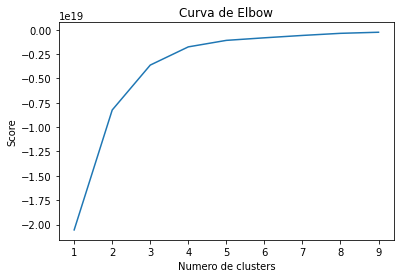

In [141]:
# Presento la curva para elegir el valor K del algoritmo
plt.plot(n_clu,score)
plt.title('Curva de Elbow')
plt.xlabel('Numero de clusters')
plt.ylabel('Score')
plt.show()

##### La curva parece aplanarse en 4, se utilizará ese valor K, operativamente es un grupo interesante para focalizar acciones

In [142]:
# calculamos el algoritmo k_means
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
# printeamos los centroides de los clusters
print(centroids)

[[7.39260796e+00 2.36268150e-03 5.43283047e-03 2.46857062e-02
  2.12086291e+03 5.12620773e-02 9.67043183e-01 5.43619747e+06
  1.53506977e+03 1.08723949e+06]
 [9.50000000e+00 2.00000000e-03 1.09500000e-02 1.69000000e-02
  9.87340000e+04 5.37249871e-02 9.40000000e-01 2.41049457e+09
  8.19000000e+04 4.82098914e+08]
 [9.85714286e+00 2.14285714e-03 9.41428571e-03 1.61857143e-02
  5.18830000e+04 5.38014593e-02 9.51428571e-01 7.44886258e+08
  1.06712857e+05 1.48977252e+08]
 [7.59770115e+00 2.84137931e-03 8.75172414e-03 2.15298851e-02
  1.87869080e+04 4.91229164e-02 9.52758621e-01 1.84726651e+08
  3.60203448e+04 3.69453301e+07]]


In [143]:
# Calculamos los clusters para todos los datos
labels = kmeans.predict(X)
# etiquetamos los datos con el cluster asignado
clusters=['1','2','3','4']
asignar=[]
for row in labels:
    asignar.append(clusters[row])
data['kmeans_cluster'] = asignar

In [144]:
data.value_counts('kmeans_cluster')

kmeans_cluster
1    5303
4      87
3       7
2       2
dtype: int64

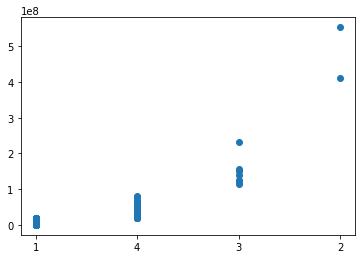

In [148]:
plt.scatter(x=data['kmeans_cluster'],y=data["total_profits_amount"])

In [150]:
cluster_1 = data.loc[data.kmeans_cluster == '2']
cluster_1


,antiquity_ages,cancellations_rate,claims_rate,delayed_handling_time_rate,sales_value,transactions_canceled_historic_rate,rating_positive,total_sales_amount,total_items_sold,total_profits_amount,kmeans_cluster
147,18,0.004,0.0147,0.0338,92800,0.056735,0.95,2.054400e+09,93618,410879941.2,2
499,1,0.000,0.0072,0.0000,104668,0.050715,0.93,2.766589e+09,70182,553317886.0,2


### 3.c Clasificacion con algoritmo DBSCAN

In [147]:
553.317.886.000000
155.350.631.400000
40.878.960.800000
410.879.941.200000

SyntaxError: invalid syntax (<ipython-input-147-d482f5492eb1>, line 1)